# hypopy tutorial, P-wave arrivals only

## Outline

- [Create synthetic data](#Create-synthetic-data)
- [Initial hypocenter locations](#Initial-hypocenter-locations)
- [Velocity data points](#Velocity-data-points)
- [Calibration shots](#Calibration-shots)
- [Constant velocity inversion](#Constant-velocity-inversion)
- [Joint hypocenter-velocity inversion parameters](#Joint-hypocenter-velocity-inversion-parameters)
- [Joint hypocenter-velocity inversion](#Joint-hypocenter-velocity-inversion)
- [Results](#Results)


In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import hypo
from ttcrpy.rgrid import Grid3d

## Create first synthetic data

Define limits and build grid

In [2]:
xmin = 0.090
xmax = 0.211
ymin = 0.080
ymax = 0.211
zmin = 0.0
zmax = 0.101

dx = 0.005   # grid cell size, we use cubic cells here

# coordinates of the nodes
x = np.arange(xmin, xmax, dx)
y = np.arange(ymin, ymax, dx)
z = np.arange(zmin, zmax, dx)

# coordinates of the center of the voxels
xx = np.arange(xmin+dx/2, xmax, dx)
yy = np.arange(ymin+dx/2, ymax, dx)
zz = np.arange(zmin+dx/2, zmax, dx)

nthreads = 4   # do calculations in parallel with 4 processes
nthreads = 1   # there is currently an issue with relocating events in parallel

g = Grid3d(x, y, z, nthreads, cell_slowness=True)

We need some receivers

In [3]:
rcv = np.array([[0.112, 0.115, 0.013],
                [0.111, 0.116, 0.040],
                [0.111, 0.113, 0.090],
                [0.151, 0.117, 0.017],
                [0.180, 0.115, 0.016],
                [0.113, 0.145, 0.011],
                [0.160, 0.150, 0.017],
                [0.185, 0.149, 0.015],
                [0.117, 0.184, 0.011],
                [0.155, 0.192, 0.009],
                [0.198, 0.198, 0.010],
                [0.198, 0.196, 0.040],
                [0.198, 0.193, 0.090]])
ircv = np.arange(rcv.shape[0]).reshape(-1, 1)   # vector of rcv indices
nsta = rcv.shape[0]

Let's create 15 events randomly located in the grid

In [4]:
nev = 15
src = np.vstack((np.arange(nev),                                            # event ID
                 np.linspace(0., 50., nev) + np.random.randn(nev),          # origin time
                 0.160 + 0.005*np.random.randn(nev),                        # x
                 0.140 + 0.005*np.random.randn(nev),                        # y
                 0.060 + 0.010*np.random.randn(nev))).T                     # z

h_true = src.copy()

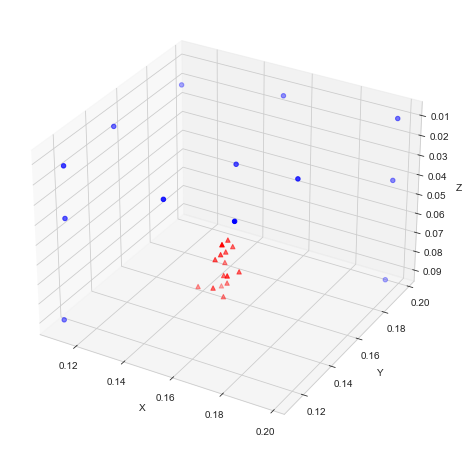

In [5]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rcv[:,0], rcv[:,1], rcv[:,2], c='b', marker='o')
ax.scatter(src[:,2], src[:,3], src[:,4], c='r', marker='^')
ax.invert_zaxis()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

For simplicity, we will use a velocity model with a small vertical gradient and mean Vp = 4 km/s

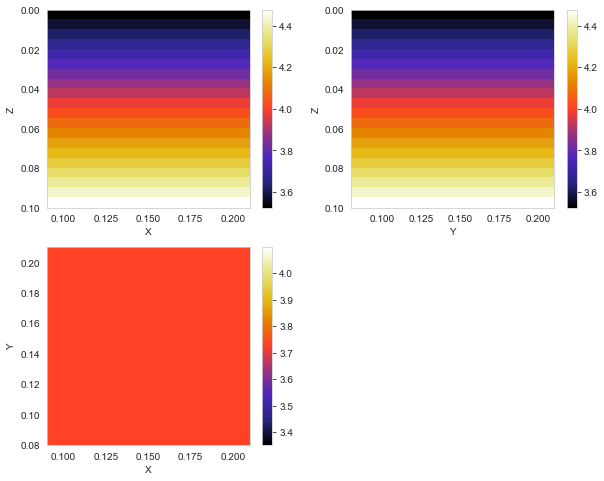

In [6]:
def Vz(z):
    return 4.0 + 10. * (z - 0.050)

Vp = np.kron(Vz(zz), np.ones((g.shape[0], g.shape[1], 1)))

plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.pcolor(x, z, np.squeeze(Vp[:,0,:].T), cmap='CMRmap',), plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(222)
plt.pcolor(y, z, np.squeeze(Vp[0,:,:].T), cmap='CMRmap'), plt.gca().invert_yaxis()
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(223)
plt.pcolor(x, y, np.squeeze(Vp[:,:,4].T), cmap='CMRmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

plt.show()

Let's now compute the travel times

The raytracing routine takes 3 input variables:
- the matrix of hypocenter data (hypo)
- the matrix of receiver coordonates (rcv)
- the slowness vector (ordered in 'C' order)

hypo and rcv must have the same number of rows, with each row corresponding to a source-receiver pair

In [7]:
slowness = 1./Vp.flatten()

src = np.kron(src, np.ones((nsta, 1)))   # use kron to replicate src-rcv pairs correctly
rcv_data = np.kron(np.ones((nev, 1)), rcv)
ircv_data = np.kron(np.ones((nev, 1)), ircv)

print(src.shape)
print(rcv_data.shape)

(195, 5)
(195, 3)


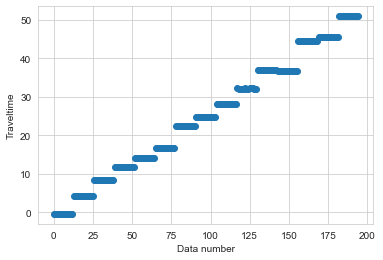

In [8]:
# call the actual raytracing method

tt = g.raytrace(src, rcv_data, slowness)

plt.plot(tt,'o')
plt.xlabel('Data number')
plt.ylabel('Traveltime')
plt.show()

Add some noise to the data

In [9]:
noise_variance = 1.e-3;  # 1 ms
tt += noise_variance*np.random.randn(tt.size)

Combine the event IDs, travel times, and receiver locations

In [10]:
data = np.hstack((src[:,0].reshape((-1,1)), tt.reshape((-1,1)), ircv_data))

## Initial hypocenter locations

Note that for efficiency reason when computing matrix M, initial hypocenters
should _not_ be equal for any two event, e.g. they shoud all be different.

Here we place the initial coordinates more or less in the center of the grid.

In [11]:
hinit = np.vstack((np.arange(nev),
                   np.linspace(0., 50., nev),
                   0.150 + 0.0001*np.random.randn(nev),
                   0.150 + 0.0001*np.random.randn(nev),
                   0.050 + 0.0001*np.random.randn(nev))).T

## Velocity data points

For illustrative purposes, let's add a couple of velocity data points to constrain the inversion

In [12]:
Vpts = np.array([[Vz(0.001), 0.100, 0.100, 0.001],
                 [Vz(0.001), 0.100, 0.200, 0.001],
                 [Vz(0.001), 0.200, 0.100, 0.001],
                 [Vz(0.001), 0.200, 0.200, 0.001],
                 [Vz(0.011), 0.112, 0.148, 0.011],
                 [Vz(0.005), 0.152, 0.108, 0.005],
                 [Vz(0.075), 0.152, 0.108, 0.075],
                 [Vz(0.011), 0.192, 0.148, 0.011]])

## Calibration shots

Let's use 5 shots recorded at most receivers

In [13]:
ncal = 5
src_cal = np.vstack((5+np.arange(ncal),
                 np.zeros(ncal),
                 0.160 +  0.005*np.random.randn(ncal),
                 0.130 +  0.005*np.random.randn(ncal),
                 0.045 +  0.005*np.random.randn(ncal))).T

src_cal = np.kron(src_cal,np.ones((nsta,1)))
rcv_cal = np.kron(np.ones((ncal,1)), rcv)
ircv_cal = np.kron(np.ones((ncal,1)), ircv)

ind = np.ones(rcv_cal.shape[0], dtype=bool)
ind[3] = 0
ind[13] = 0
ind[15] = 0
src_cal = src_cal[ind,:]
rcv_cal = rcv_cal[ind,:]
ircv_cal = ircv_cal[ind,:]

tcal = g.raytrace(src_cal, rcv_cal, slowness)
caldata = np.column_stack((src_cal[:,0], tcal, ircv_cal, src_cal[:,2:], np.zeros(tcal.shape)))

## Constant velocity inversion

Before running the joint hypocenter-velocity inversion (JHVI), we use the constant velocity location algorithm.  This will improve convergence of the JHVI.

Initial velocity model is of course homogeneous, we take the mean value of the data points.

In [14]:
Vinit = np.mean(Vpts[:,0])

hinit2, res = hypo.hypoloc(data, rcv, V=Vinit, hinit=hinit, maxit=15, convh=0.001, verbose=True)


 *** Hypocenter inversion ***

Locating hypocenters no 0
     Converged at iteration 3
Locating hypocenters no 1
     Converged at iteration 3
Locating hypocenters no 2
     Converged at iteration 3
Locating hypocenters no 3
     Converged at iteration 3
Locating hypocenters no 4
     Converged at iteration 2
Locating hypocenters no 5
     Converged at iteration 3
Locating hypocenters no 6
     Converged at iteration 3
Locating hypocenters no 7
     Converged at iteration 2
Locating hypocenters no 8
     Converged at iteration 3
Locating hypocenters no 9
     Converged at iteration 3
Locating hypocenters no 10
     Converged at iteration 3
Locating hypocenters no 11
     Converged at iteration 3
Locating hypocenters no 12
     Converged at iteration 3
Locating hypocenters no 13
     Converged at iteration 3
Locating hypocenters no 14
     Converged at iteration 3

 ** Inversion complete **



Let's have a look at the residuals

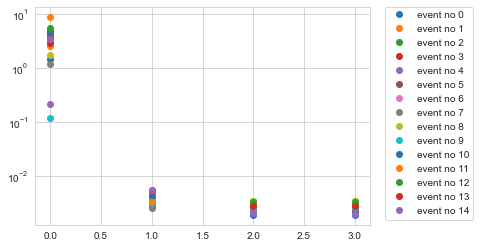

In [15]:
for n in range(res.shape[0]):
    ind = res[n, :] > 0
    plt.semilogy(res[n, ind], 'o', label='event no {}'.format(n))
plt.legend(loc='lower left', bbox_to_anchor=(1.03, 0.0))
plt.show()

Look now at error on hypocenter location

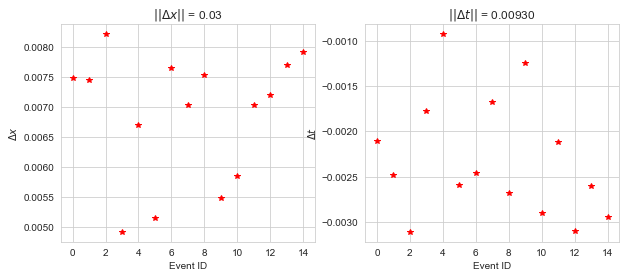

In [16]:
err_x = hinit2[:,2:5] - h_true[:,2:5]
err_x = np.sqrt(np.sum(err_x**2, axis=1))
err_t = hinit2[:,1] - h_true[:,1]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(err_x,'r*')
plt.ylabel(r'$\Delta x$')
plt.xlabel('Event ID')
plt.title(r'$\|\|\Delta x\|\|$ = {0:3.2f}'.format(np.linalg.norm(err_x)))
plt.subplot(122)
plt.plot(err_t,'r*')
plt.ylabel(r'$\Delta t$')
plt.xlabel('Event ID')
plt.title(r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_t)))

plt.show()

## Joint hypocenter-velocity inversion parameters

Define inversion parameters

In [17]:
Vpmin = 3.5
Vpmax = 4.5
PAp = 1.0
Vsmin = 1.9
Vsmax = 2.3
PAs = 1.0
Vlim = (Vpmin, Vpmax, PAp, Vsmin, Vsmax, PAs)
        
dVp_max = 0.1
dx_max = 0.01
dt_max = 0.01
dVs_max = 0.1
dmax = (dVp_max, dx_max, dt_max, dVs_max)
        
λ = 2.     # weight of smoothing constraint
γ = 1.     # weight of penalty constraint
α = 1.     # weight of velocity data point constraint
wzK = 0.1  # weight for vertical smoothing (w.r. to horizontal smoothing)
lagran = (λ, γ, α, wzK)

par = hypo.InvParams(maxit=3, maxit_hypo=10, conv_hypo=0.001, Vlim=Vlim, dmax=dmax,
                     lagrangians=lagran, invert_vel=True, verbose=True)

Let's build an initial velocity model slightly off the true one

In [18]:
def Vz2(z):
    return 4. + 7.5 * (z - 0.050)

Vpinit = np.kron(Vz2(zz), np.ones((g.shape[0], g.shape[1], 1)))
Vpinit = Vpinit.flatten()

## Joint hypocenter-velocity inversion

Run the inversion

In [19]:
h, V, sc, res = hypo.jointHypoVel(par, g, data, rcv, Vpinit, hinit2, caldata=caldata, Vpts=Vpts)


 *** Joint hypocenter-velocity inversion ***

Building velocity data point matrix D
Building regularization matrix K

Starting iterations

Iteration 1 - Updating velocity model
  Updating penalty vector
  Raytracing
  Building matrix L
    Event ID 0
    Event ID 1
    Event ID 2
    Event ID 3
    Event ID 4
    Event ID 5
    Event ID 6
    Event ID 7
    Event ID 8
    Event ID 9
    Event ID 10
    Event ID 11
    Event ID 12
    Event ID 13
    Event ID 14
  Assembling matrices and solving system
    calling minres with system of size 12493 x 12493
Iteration 1 - Relocating events
  Updating event ID 0 (1/15)
    Updating all hypocenter params - converged at iteration 2
  Updating event ID 1 (2/15)
    Updating all hypocenter params - converged at iteration 2
  Updating event ID 2 (3/15)
    Updating all hypocenter params - converged at iteration 2
  Updating event ID 3 (4/15)
    Updating all hypocenter params - converged at iteration 2
  Updating event ID 4 (5/15)
    Updating a

## Results

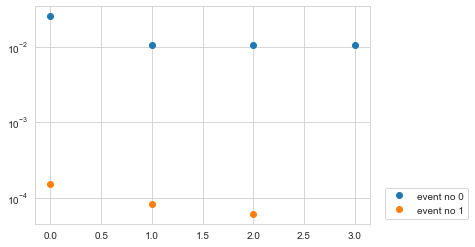

In [22]:
for n in range(len(res)):
    ind = res[n] > 0
    plt.semilogy(res[n][ind], 'o', label='event no {}'.format(n))
plt.legend(loc='lower left', bbox_to_anchor=(1.03, 0.0))
plt.show()

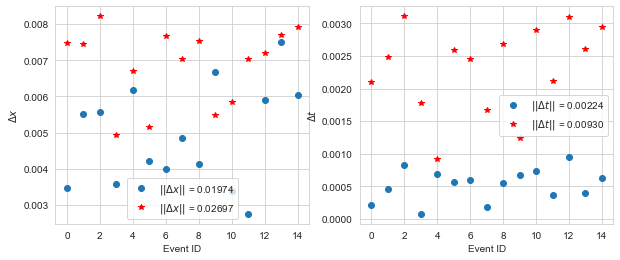

In [23]:
err_xc = hinit2[:,2:5] - h_true[:,2:5]
err_xc = np.sqrt(np.sum(err_xc**2, axis=1))
err_tc = hinit2[:,1] - h_true[:,1]

err_x = h[:,2:5] - h_true[:,2:5]
err_x = np.sqrt(np.sum(err_x**2, axis=1))
err_t = h[:,1] - h_true[:,1]

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(err_x,'o',label=r'$\|\|\Delta x\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_x)))
plt.plot(err_xc,'r*',label=r'$\|\|\Delta x\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_xc)))
plt.ylabel(r'$\Delta x$')
plt.xlabel('Event ID')
plt.legend()
plt.subplot(122)
plt.plot(np.abs(err_t),'o',label=r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_t)))
plt.plot(np.abs(err_tc),'r*',label=r'$\|\|\Delta t\|\|$ = {0:6.5f}'.format(np.linalg.norm(err_tc)))
plt.ylabel(r'$\Delta t$')
plt.xlabel('Event ID')
plt.legend()

plt.show()

We can see a good improvement on relocation over constant velocity inversion (blue points are error after joint inversion, red are results for constant velocity).  What about the velocity model?

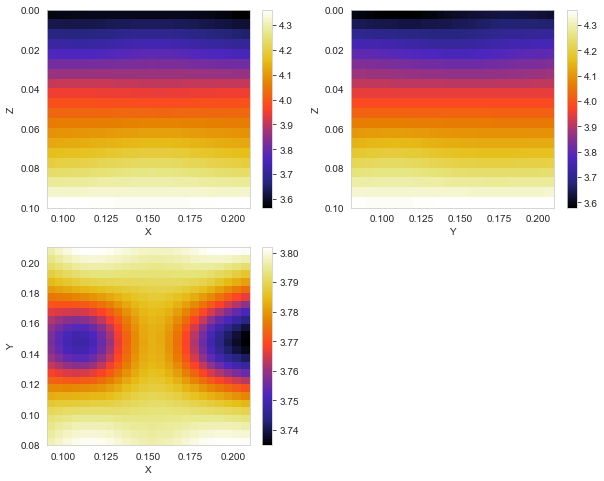

In [24]:
V3d = V.reshape(g.shape)

plt.figure(figsize=(10,8))
plt.subplot(221)
plt.pcolor(x,z,np.squeeze(V3d[:,9,:].T), cmap='CMRmap',), plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(222)
plt.pcolor(y,z,np.squeeze(V3d[8,:,:].T), cmap='CMRmap'), plt.gca().invert_yaxis()
plt.xlabel('Y')
plt.ylabel('Z')
plt.colorbar()
plt.subplot(223)
plt.pcolor(x,y,np.squeeze(V3d[:,:,4].T), cmap='CMRmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()

plt.show()

Let's look at station corrections

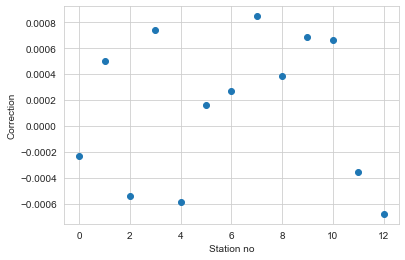

In [25]:
plt.plot(sc,'o')
plt.xlabel('Station no')
plt.ylabel('Correction')
plt.show()